<a href="https://colab.research.google.com/github/Siarzis/ai-tutor/blob/main/lfc_disturbance_prediction_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Data Loading & Plotting

Load and plot the training data

                 0       0.1     0.2
0         0.100000  0.000000  0.0000
1         0.200000  0.000000  0.0000
2         0.300000  0.000000  0.0000
3         0.400000  0.000000  0.0000
4         0.500000  0.000000  0.0000
...            ...       ...     ...
13545  1349.599976  0.006909  0.0371
13546  1349.699951  0.006527  0.0371
13547  1349.800049  0.006152  0.0371
13548  1349.900024  0.005782  0.0371
13549  1350.000000  0.005417  0.0371

[13550 rows x 3 columns]
                 0       0.1     0.2
0         0.100000  0.000000  0.0000
10        1.100000  0.000000  0.0000
20        2.100000  0.000000  0.0000
30        3.100000  0.000000  0.0000
40        4.100000  0.000000  0.0000
...            ...       ...     ...
13500  1345.099976  0.028385  0.0371
13510  1346.099976  0.023183  0.0371
13520  1347.099976  0.018080  0.0371
13530  1348.099976  0.013271  0.0371
13540  1349.099976  0.008900  0.0371

[1355 rows x 3 columns]


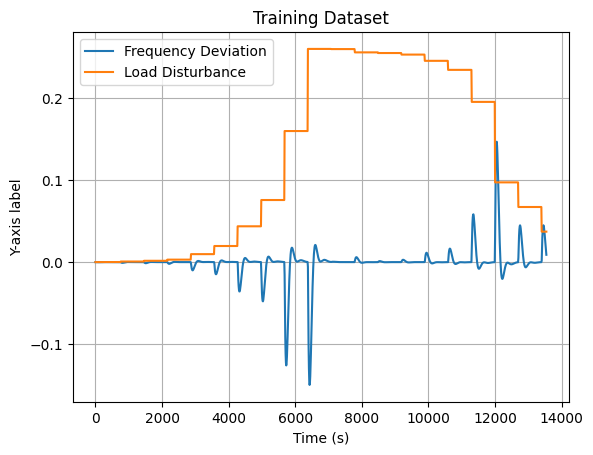

In [3]:
train_dataset_df = pd.read_csv('train_dataset.csv', dtype=np.float32)
print(train_dataset_df)
train_dataset_df = train_dataset_df[train_dataset_df.index % 10 == 0]
print(train_dataset_df)

plt.figure()
plt.plot(train_dataset_df.iloc[:, 1], label='Frequency Deviation')
plt.plot(train_dataset_df.iloc[:, 2], label='Load Disturbance')
plt.xlabel('Time (s)')
plt.ylabel('Y-axis label')
plt.title('Training Dataset')
plt.legend()
plt.grid(True)
plt.show()

Load and plot the testing data

               0       0.1   0.2
0       0.100000  0.000000  0.00
10      1.100000  0.000000  0.00
20      2.100000  0.000000  0.00
30      3.100000  0.000000  0.00
40      4.100000  0.000000  0.00
...          ...       ...   ...
1970  195.300003  0.000003  0.05
1980  196.300003  0.000003  0.05
1990  197.300003  0.000003  0.05
2000  198.300003  0.000003  0.05
2010  199.300003  0.000002  0.05

[202 rows x 3 columns]


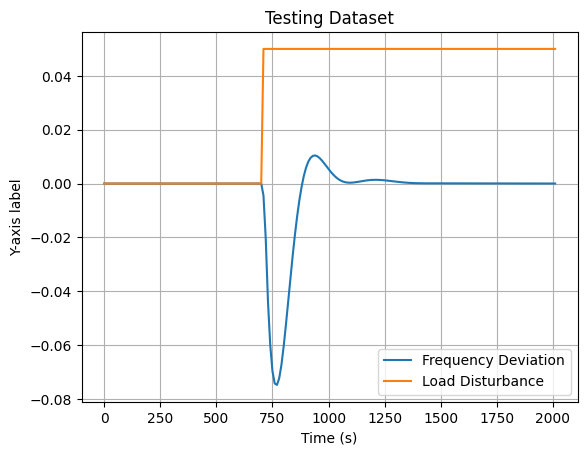

In [4]:
test_dataset_df = pd.read_csv('test_dataset.csv', dtype=np.float32)
test_dataset_df = test_dataset_df[test_dataset_df.index % 10 == 0]
print(test_dataset_df)


plt.figure()
plt.plot(test_dataset_df.iloc[:, 1], label='Frequency Deviation')
plt.plot(test_dataset_df.iloc[:, 2], label='Load Disturbance')
plt.xlabel('Time (s)')
plt.ylabel('Y-axis label')
plt.title('Testing Dataset')
plt.legend()
plt.grid(True)
plt.show()

# Data preprocess

**Pipeline description**:

csv format →  data frame → numpy → tensor

In [5]:
def windowed_array(arr, window_size):
    # Calculate the number of subarrays
    num_windows = len(arr) - window_size + 1

    # Create an empty array to store the result
    result = np.empty((num_windows, window_size), dtype=arr.dtype)

    # Fill the result array with windowed slices
    for i in range(num_windows):
        result[i] = arr[i:i+window_size]

    return result

class CustomDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = torch.tensor(inputs)
        self.inputs = torch.unsqueeze(self.inputs, dim=2)

        self.outputs = torch.tensor(outputs)
        self.outputs = torch.unsqueeze(self.outputs, dim=2)

    def __len__(self):
        return len(self.inputs)  # Assuming all arrays have the same length

    def __getitem__(self, index):
        sample = tuple((self.inputs[index], self.outputs[index]))
        return sample

In [6]:
# for now, keep historical_window equal to prediction_window
# if not equal, the consider padding method
historical_window = 5
prediction_window = 5

# training data preprocess

X_train = train_dataset_df.iloc[:, 1].to_numpy()
y_train = train_dataset_df.iloc[:, 2].to_numpy()

X_train = X_train[:len(X_train)-historical_window]
y_train = y_train[prediction_window:]

X_train = windowed_array(X_train, historical_window)
y_train = windowed_array(y_train, prediction_window)

print(len(X_train), len(y_train))
print(X_train[2], y_train[2])

train_tensor = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_tensor, batch_size=64, shuffle=True)

# testing data preprocess

X_test = test_dataset_df.iloc[:, 1].to_numpy()
y_test = test_dataset_df.iloc[:, 2].to_numpy()

X_test = X_test[:len(X_test)-historical_window]
y_test = y_test[prediction_window:]

X_test = windowed_array(X_test, historical_window)
y_test = windowed_array(y_test, prediction_window)

test_tensor = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_tensor, batch_size=64, shuffle=True)

1346 1346
[ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00 -5.1085e-05] [1.e-04 1.e-04 1.e-04 1.e-04 1.e-04]


# RNN Definition & Initilization

Define the architecture of the RNN using a class

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(5, self.hidden_size)

In [8]:
# define feedforward neural network architecture
input_size = 1
hidden_size = 8
output_size = 1

# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create an instance of the neural network
net = RNN(input_size, hidden_size, output_size)

# define loss function and optimizer
criterion = nn.MSELoss() # for classification tasks logarithmic/cross-entropy loss function is mainly used
optimizer = optim.SGD(net.parameters(), lr=0.01)

# RNN Training

In [9]:
epochs = 10

training_loss = []

for e in range(epochs):

    # initialize the hidden state
    hidden = net.initHidden()

    total_loss = 0

    # forward pass
    for i, (historical_seq, targets_seq) in enumerate(train_tensor):

        # timeseries_batch[0] -> the first sequence of historical observations included in i_batch
        # timeseries_batch -> all sequences of historical observations included in i_batch
        prediction = []

        prediction, hidden = net(historical_seq, hidden)

        # compute loss and store the total loss in each epoch
        loss = criterion(prediction, targets_seq)

        # backpropagation
        loss.backward() # propagate the loss backwards
        optimizer.step() # update weights

        total_loss += loss.item()

        # nullify gradients
        optimizer.zero_grad()

    training_loss.append(total_loss)

    print('Epoch [{}/{}], Loss: {:.4f}'.format(e+1, epochs, total_loss))

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

Plot training loss

In [ ]:
# Plot the training loss
plt.plot(training_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

Model evaluation

In [ ]:
for i, (test_input, test_target) in enumerate(test_tensor):
    if i ==190:
        predicted, hidden = net(test_input, torch.zeros(5, hidden_size))

        test_input = test_input.numpy()
        test_target = test_target.numpy()
        predicted = predicted.detach().numpy()

        t_max = len(test_target) + len(test_target)
        t = np.arange(0, t_max)

        # Plot dots
        plt.scatter(t[:len(test_input)], test_input, color='green', edgecolors='black', s=12)
        plt.scatter(t[len(predicted):], predicted, color='orange', marker='X', edgecolors='black', s=30)
        plt.scatter(t[len(test_target):], test_target, color='blue', marker='X', edgecolors='black', s=30)

        # Set labels and title
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.title('Scatter Plot')

        # Show plot
        plt.show()

In [ ]:
num_points = 150
seq_length = 10

t = np.linspace(0, 10*np.pi, num_points)
sine_values = np.sin(t)
cosine_values = np.cos(t)



# Convert to PyTorch tensors
sine_tensor = torch.tensor(sine_values, dtype=torch.float32)
cosine_tensor = torch.tensor(cosine_values, dtype=torch.float32)

# Create sequences of sine values as input and corresponding cosine values as output
input_data = torch.stack([sine_tensor[i:i+seq_length] for i in range(num_points - seq_length)]).unsqueeze(2)
output_data = torch.stack([cosine_tensor[i+seq_length] for i in range(num_points - seq_length)]).unsqueeze(1)

print(input_data[0], output_data[0])